In [ ]:
# Imports
import torch
import torchvision
# It contains some utilities for working with image data. It also contains some famous datasets.
from torchvision.datasets import MNIST # imported MNIST class

In [ ]:
# Download training dataset
dataset = MNIST(root='data/', download=True)
# we need to download the training ds, for this we are using MNIST class as a constructor within which we're passing root as the directory where the data will be downloaded
# The data will downloaded under the directory name called 'data'. we've set the download to true to tell if dataset is not present, then download the data.
# the dataset is automatically converted into pytorch dataset object

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
len(dataset)

60000

In [ ]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)
# sim. we've downloaded the test set, by passing train to false. it tells mnist to download the test set instead of training set

10000

In [ ]:
dataset[0]
# it is a sample element from the training set. It is a pair, it consists of 2 things. first is the image it is an object of PIL.image.image class, it is a part of 
# python imaging library called pillow. it reads the file which is the format of jpd or png and converts it into an object which can be used in python.
# second it contains the label of the image i.e what it contains.

(<PIL.Image.Image image mode=L size=28x28 at 0x7FD368FC1190>, 5)

In [ ]:
#Lets look at some images, for which we're importing matplotlib particularly pyplot.
import matplotlib.pyplot as plt
%matplotlib inline


Label: 5


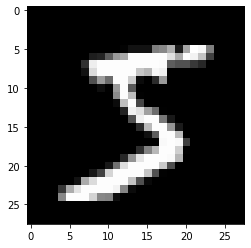

In [ ]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
# imshow is used to display images ans we're setting cmap(colour map) to gray as these images are b&w
print('Label:', label)

Label: 3


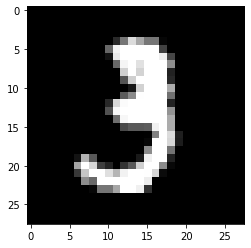

In [ ]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)



```
The above visualization steps are necessary because if look at the images we could find that these are of only 28 by 28 px, 
if seen from a distance even human eyes sometimes might not recognize them.
Thus it is better to visualize our data before processing it just to grasp about what are gettng ourselves into.
```



In [ ]:
# pytorch doesn't know how to work wth images. it is a library for processing tensors.
# thus we need to tranform them into tensors
# "tranforms": converts any type of data into tensors
import torchvision.transforms as transforms

In [ ]:
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [ ]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)
# since our images are in the form of pairs, so when we are printing it we need need to label both the fields, sim. to what we've done above.
# torch.shape consists of 3 channels the last 2 channels are the dimensions of the image while the 1st channel tracks the color channels. i.e "1" shows gray scale type

torch.Size([1, 28, 28]) 5


In [ ]:
# 0 represents black, 1 represents while. values in between them represents the different shades of gray
print(img_tensor[0,10:15,10:15])
# passing above argument we are tracking '0' as the first channel and then tracking 10th to 15th row and 10th to 15th coloumn.
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


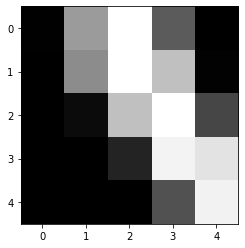

In [ ]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

In [ ]:
# since we want validation set, we can get it from the training set by dividing it. 
# Since our data is not time dependent, so this time we're dividing our dataset using the random_split method from pytorch.
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
# in the above step we invoked random_split method, passed it on dataset and set the size of the train and validation set.
len(train_ds), len(val_ds)

(50000, 10000)



```
Ques. Why we randomly select the validation set?

This is because most of the time the dataset is in some sort of order. i.e. MNIST dataset consists of 0's images followed by 1 then 2 and so on.
thus if we take anyone part of the dataset then it will definitely lack the instance of almost all the values present in the dataset.

for ex. if we take the last part of the dataset as the VDS, in that case it will only contains 8 and 9 hence we cannot build a perfect model
```



In [ ]:
# now that we have divided our dataset, we are now creating dataloaders. we are using the batch size of 128
# there are 50K images and 10k validation images we cannot put them into a single gradient descent loop because
# 1. They might not fit into the ram
# 2. Even if they do fit, the performance would be very slow. 
# and we can achieve much better accuracy with batches of small size.
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
# we're creating the train loader with train_ds, passing the batch size, and setting shuffle to true so that batches are generated randomly in each epoch.
# this ranomization speeds up the training and helps our model to generalize.
val_loader = DataLoader(val_ds, batch_size)
# since we need validation set to check the accuracy we dont need to shuffle it.


```
Model

Now that we have prepared our data loaders, we can define our model.

A logistic regression model contains weights and bias matrices, 
and the output is obtained using simple matrix operations (pred = x @ w.t() + b).

we will use nn.Linear to create the model instead of manually creating and initializing the matrices.

Since nn.Linear expects each training example to be a vector, each 1x28x28 image tensor is flattened into a vector of size 784 (28*28) 
before being passed into the model.

The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). 
The predicted label for an image is simply the one with the highest probability.
```



In [ ]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

In [ ]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[ 0.0163, -0.0147,  0.0220,  ..., -0.0128, -0.0169,  0.0051],
        [ 0.0153,  0.0333,  0.0282,  ..., -0.0123, -0.0196, -0.0069],
        [ 0.0154,  0.0151, -0.0176,  ..., -0.0170, -0.0012,  0.0350],
        ...,
        [ 0.0157,  0.0042, -0.0120,  ..., -0.0188,  0.0354,  0.0300],
        [ 0.0191,  0.0228,  0.0094,  ...,  0.0234, -0.0068, -0.0019],
        [ 0.0091,  0.0253, -0.0187,  ...,  0.0085, -0.0170,  0.0120]],
       requires_grad=True)

In [ ]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0127,  0.0056,  0.0150,  0.0084,  0.0244,  0.0326, -0.0231,  0.0147,
        -0.0287, -0.0107], requires_grad=True)

In [ ]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break
# since the images are in 4d shape thus we need need to flatten it into 2d vectors i.e. convert them into vectors of size 784.

tensor([7, 0, 5, 9, 6, 3, 8, 1, 4, 8, 6, 4, 1, 4, 5, 3, 9, 2, 7, 1, 4, 3, 8, 4,
        3, 7, 1, 8, 9, 1, 8, 5, 1, 5, 4, 2, 1, 8, 8, 1, 5, 1, 3, 1, 3, 7, 7, 1,
        6, 9, 2, 4, 0, 8, 1, 8, 9, 7, 3, 8, 8, 8, 8, 9, 0, 9, 5, 6, 5, 3, 1, 2,
        1, 4, 1, 9, 3, 1, 5, 8, 8, 7, 1, 9, 7, 9, 2, 9, 9, 9, 8, 1, 5, 8, 6, 9,
        0, 9, 5, 5, 2, 1, 2, 7, 1, 9, 0, 4, 7, 2, 6, 8, 8, 6, 1, 4, 7, 0, 4, 9,
        9, 2, 0, 0, 9, 0, 0, 7])
torch.Size([128, 1, 28, 28])


RuntimeError: ignored

In [ ]:
images.shape

torch.Size([128, 1, 28, 28])

In [ ]:
images.reshape(128, 784).shape
# we're are not modifying the shape of the image, we're just looking at the with different perspective i.e. in vectors

torch.Size([128, 784])

In [ ]:
# we're extending nn.module class
# we've inherited the constructor of the parent class and extended it "self.linear".
# then we're defining a method named forward which will simply convert the images from 4d to 2d
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()
# xb = xb.reshape(-1, 784): instea of 128 we could just write 128 but pytorch already knows the input vector xb has certain dimensions inshort how many total elements it has
# thus if we simply tell that we need 2nd dimension as 784, putorch will divide total elements by 784 and get the other dimension
# this is very useful because
# 1. we dont have to perform the entire calc.
# 2. It makes oue model generic i.e. it is not tied or hard bound to a specific batch size so even if we change the batch size to something else, this fn. will work.


# this is our custom model using pytorch.

In [ ]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [ ]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())
# we've defined "linear" by hard code, but inside it has weights and bais. this is the feature of pytorch
# another feature is that no matter how many such layers are there pytorch will take all their weights and baises and bundle them into a single list 
# which we can access using "model.parameters()".

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 0.0020, -0.0120, -0.0075,  ...,  0.0342, -0.0337, -0.0233],
         [-0.0345, -0.0074, -0.0145,  ..., -0.0332,  0.0071, -0.0067],
         [ 0.0305, -0.0179,  0.0182,  ..., -0.0122, -0.0301, -0.0272],
         ...,
         [ 0.0326,  0.0276,  0.0289,  ..., -0.0195,  0.0189,  0.0300],
         [-0.0333,  0.0280, -0.0089,  ...,  0.0055, -0.0061,  0.0259],
         [-0.0250, -0.0140,  0.0285,  ...,  0.0322,  0.0339,  0.0182]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0217,  0.0003,  0.0259,  0.0328, -0.0061,  0.0140, -0.0193,  0.0174,
          0.0220, -0.0072], requires_grad=True)]

In [ ]:
# we can use this customized model the same way because we're just extending the nn.Module class.
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
# "outputs[:2]": printing the first 2 outputs.

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.1561, -0.0575,  0.0257,  0.4137, -0.3011, -0.4024,  0.1704, -0.0813,
          0.2073,  0.0905],
        [ 0.2132, -0.0520,  0.0410,  0.4731, -0.4196, -0.0120,  0.0987, -0.0760,
          0.2289, -0.2261]])




```
Observations from the above predictions:

1. Some prob. are -ve.
2. Since we know that sum of the probabilities should add up to make 1, but in the above case it is not following that rule
3. Model should not predict all the labels with a good prob. Instead it should predict any one label with a very high prob. 
and viceversa for others

Thus we will be using softmax function to resolve the above problems
```



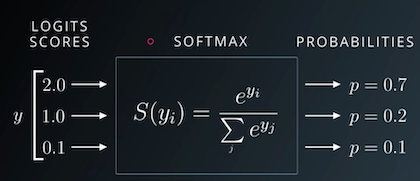

In [ ]:
import torch.nn.functional as F
# it contains softmax implementation

In [ ]:
outputs[:2]

tensor([[-0.1561, -0.0575,  0.0257,  0.4137, -0.3011, -0.4024,  0.1704, -0.0813,
          0.2073,  0.0905],
        [ 0.2132, -0.0520,  0.0410,  0.4731, -0.4196, -0.0120,  0.0987, -0.0760,
          0.2289, -0.2261]], grad_fn=<SliceBackward0>)

In [ ]:

# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.0840, 0.0927, 0.1008, 0.1486, 0.0727, 0.0657, 0.1165, 0.0906, 0.1209,
         0.1075],
        [0.1172, 0.0899, 0.0986, 0.1519, 0.0622, 0.0935, 0.1045, 0.0877, 0.1190,
         0.0755]])
Sum:  0.9999999403953552


In [ ]:
# since we've to pick the label with the highest prob. we're using "torch.max to get the label along the dimension 1"
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([3, 3, 7, 3, 3, 3, 9, 3, 3, 3, 8, 3, 6, 0, 3, 7, 8, 3, 3, 2, 3, 3, 3, 3,
        7, 3, 8, 8, 7, 3, 3, 3, 6, 3, 3, 3, 6, 3, 3, 8, 3, 3, 9, 3, 1, 3, 7, 3,
        2, 3, 3, 3, 6, 3, 0, 3, 8, 3, 3, 8, 3, 8, 1, 3, 8, 3, 3, 3, 3, 3, 3, 3,
        3, 2, 3, 8, 6, 3, 3, 3, 8, 6, 3, 6, 3, 8, 3, 3, 9, 3, 3, 2, 3, 3, 2, 3,
        3, 3, 6, 3, 3, 3, 2, 7, 2, 3, 2, 8, 9, 2, 8, 3, 2, 3, 6, 7, 6, 3, 8, 7,
        3, 2, 3, 3, 3, 2, 7, 3])
tensor([0.1486, 0.1519, 0.1149, 0.1367, 0.1377, 0.1199, 0.1231, 0.1206, 0.1402,
        0.1471, 0.1208, 0.1623, 0.1357, 0.1228, 0.1604, 0.1286, 0.1396, 0.1386,
        0.1358, 0.1236, 0.1325, 0.1606, 0.1242, 0.1575, 0.1273, 0.1406, 0.1355,
        0.1337, 0.1352, 0.1473, 0.1336, 0.1443, 0.1271, 0.1464, 0.1390, 0.1181,
        0.1304, 0.1389, 0.1393, 0.1343, 0.1388, 0.1196, 0.1117, 0.1399, 0.1286,
        0.1325, 0.1516, 0.1280, 0.1203, 0.1217, 0.1422, 0.1302, 0.1393, 0.1562,
        0.1329, 0.1580, 0.1195, 0.1350, 0.1671, 0.1322, 0.1505, 0.1356, 0.1248,
       

In [ ]:
labels

tensor([5, 8, 5, 7, 6, 1, 6, 5, 3, 7, 4, 8, 9, 0, 6, 0, 4, 5, 7, 1, 2, 3, 5, 2,
        2, 9, 4, 2, 2, 5, 1, 5, 7, 6, 9, 9, 6, 5, 6, 9, 6, 3, 1, 3, 0, 0, 2, 1,
        9, 3, 8, 4, 3, 3, 0, 2, 5, 4, 2, 0, 0, 0, 5, 7, 8, 5, 0, 2, 3, 8, 5, 2,
        8, 0, 1, 4, 4, 6, 4, 5, 7, 0, 0, 7, 2, 7, 3, 3, 1, 7, 3, 1, 5, 8, 2, 8,
        4, 3, 0, 5, 1, 4, 1, 1, 7, 3, 4, 0, 1, 9, 0, 6, 2, 8, 6, 2, 5, 7, 0, 2,
        8, 1, 6, 3, 8, 1, 3, 7])

In [ ]:
outputs[:2]

tensor([[-0.1561, -0.0575,  0.0257,  0.4137, -0.3011, -0.4024,  0.1704, -0.0813,
          0.2073,  0.0905],
        [ 0.2132, -0.0520,  0.0410,  0.4731, -0.4196, -0.0120,  0.0987, -0.0760,
          0.2289, -0.2261]], grad_fn=<SliceBackward0>)

In [ ]:
torch.sum(preds == labels)
#"preds == labels": Since this boolean when we apply torch.sum to it, it will return the total no. of predictions which comes out to be true. 

tensor(20)

In [ ]:
# we can calc. the accuracy from the outputs itself because even after applying softmax, the relative order of the outputs won't change.
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
# " '_', preds": For the accuracy we're just concerned with the predictions and not the probs. thus we have used '_' inplace of it.

In [ ]:
accuracy(outputs, labels)

tensor(0.1562)

In [ ]:
probs

tensor([[0.0840, 0.0927, 0.1008,  ..., 0.0906, 0.1209, 0.1075],
        [0.1172, 0.0899, 0.0986,  ..., 0.0877, 0.1190, 0.0755],
        [0.1028, 0.1127, 0.1145,  ..., 0.1149, 0.1090, 0.0955],
        ...,
        [0.0870, 0.0828, 0.1318,  ..., 0.1125, 0.0954, 0.1136],
        [0.0911, 0.1065, 0.0958,  ..., 0.1104, 0.1008, 0.0951],
        [0.0755, 0.0978, 0.1056,  ..., 0.1044, 0.1025, 0.0807]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
outputs

tensor([[-0.1561, -0.0575,  0.0257,  ..., -0.0813,  0.2073,  0.0905],
        [ 0.2132, -0.0520,  0.0410,  ..., -0.0760,  0.2289, -0.2261],
        [ 0.0535,  0.1449,  0.1606,  ...,  0.1643,  0.1119, -0.0211],
        ...,
        [-0.0677, -0.1178,  0.3468,  ...,  0.1884,  0.0235,  0.1983],
        [-0.0980,  0.0583, -0.0477,  ...,  0.0942,  0.0027, -0.0550],
        [-0.2480,  0.0108,  0.0878,  ...,  0.0767,  0.0581, -0.1811]],
       grad_fn=<AddmmBackward0>)

In [ ]:
labels

tensor([5, 8, 5, 7, 6, 1, 6, 5, 3, 7, 4, 8, 9, 0, 6, 0, 4, 5, 7, 1, 2, 3, 5, 2,
        2, 9, 4, 2, 2, 5, 1, 5, 7, 6, 9, 9, 6, 5, 6, 9, 6, 3, 1, 3, 0, 0, 2, 1,
        9, 3, 8, 4, 3, 3, 0, 2, 5, 4, 2, 0, 0, 0, 5, 7, 8, 5, 0, 2, 3, 8, 5, 2,
        8, 0, 1, 4, 4, 6, 4, 5, 7, 0, 0, 7, 2, 7, 3, 3, 1, 7, 3, 1, 5, 8, 2, 8,
        4, 3, 0, 5, 1, 4, 1, 1, 7, 3, 4, 0, 1, 9, 0, 6, 2, 8, 6, 2, 5, 7, 0, 2,
        8, 1, 6, 3, 8, 1, 3, 7])



```
If we look at the accuracy of the model, we could find the accuracy is very low this is because we haven't train our model yet.

Till now we have just set up the model so that we can put an image, get its output and extract and compare the label out of it

The outputs and the labels are very different because we have randomly initialised weights and baises, Now we need to adjust them.

We have calc. the accuracy but we can't use it as loss function to optimize the model using gradient descent because:
1. It's not a differentiable function. torch.max and == are both non-continuous and non-differentiable operations, so we can't use 
the accuracy for computing gradients w.r.t the weights and biases.
2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback 
for incremental improvements.

Ex. Suppose for a label model has an accuracy of .3, another model for the same label has an accuracy of .5, so we nedd to give the feedback to 
the model with higher accuracy telling it is heading in the right direction but in the case of accuracy if the output is wrong, the prob. 
of the correct label doesn't matter and it will not give feedback to the model
```




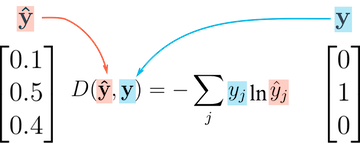

For each output row, pick the predicted probability for the correct label. E.g., if the predicted probabilities for an image are [0.1, 0.3, 0.2, ...] and the correct label is 1, we pick the corresponding element 0.3 and ignore the rest.

Then, take the logarithm of the picked probability. If the probability is high, i.e., close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.



Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.
Unlike accuracy, cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for the loss function.

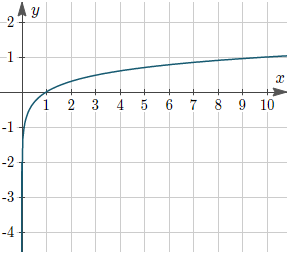

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the torch.nn.functional package. Moreover, it also performs softmax internally, so we can directly pass in the model's outputs without converting them into probabilities.

In [ ]:
loss_fn = F.cross_entropy
# cross entropy is commonly used as loss fn. for classification problems
# It is almost always used with softmax and, thus it applies softmax internally automatically
# so we can directly pass the outputs and the labels

In [ ]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)
# first it applies softmax to the outputs then it applies cross entropy
# Finally it takes average across the entire batch
# "2.3034": this is the final entropy, to interpret this no. we can use e^-2.3034, which gives about 0.0999 ~ '0.1'.
# "0.1": It is the predicted prob. of the correct label. the lower the loss, the better the model is. this value is bad.

tensor(2.3034, grad_fn=<NllLossBackward0>)




```
Training: 

for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients

    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics

    # Log epoch, loss & metrics for inspection
```



In [ ]:
# now since we have defined data loader,models and loss functions. we can now train our model
# We are using stochastic gradient descent as an optimizer 
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr) 
# What Optimizer ultimately does is that it subtracts a small quantity from the params proportional to the gradient, and it is computed by the loss fn. 
#Lr is that quantity. It helps preventing the model from jumping too far from the weight it curently have.
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward() # to compute gradients
            optimizer.step() # it changes the weight using GD and learning rate. The resultnt weights will leads to lower loss.
            optimizer.zero_grad() # Resetting gradients back to 0
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history



```
The fit function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.

Configurations like batch size, learning rate, etc. (called hyperparameters), need to picked in advance while training machine learning models. 
Choosing the right hyperparameters is critical for training a reasonably accurate model within a reasonable amount of time. 

Let's define the evaluate function, used in the validation phase of fit.
```



In [ ]:
l1 = [1, 2, 3, 4, 5]

In [ ]:
l2 = [x*2 for x in l1]
l2

[2, 4, 6, 8, 10]

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader] # here we are doing list comprehensions
    # for every batch in validation set we are invoking model.validation_step fn. within which we're passing batch
    # it will return bunch of loss and accuracies and these are getting stored in outputs iin batches.
    return model.validation_epoch_end(outputs) # We're now passing the batchwise outputs to this function which will average out the list and return the avg val.

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch): # it takes the batch of data ans returns the loss
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
# In the training step we're taking the images and the labels from the batch then we're passing the image to the model (constructor(self) is passed so we can call the model later)
# Then we're calculating the loss by passing the output and the labels. Since every model will have diff. loss, thus we're defining training step as a method inside the model
#i.e. we can invoke the training step inside the fit function

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc} # returing the output as dictionary
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [ ]:
result0 = evaluate(model, val_loader)
result0
# We're checking the accuracy of the model before trainig the model
# acc. comes out to be 14%, Loss comes out to be 2.29

{'val_loss': 2.2940964698791504, 'val_acc': 0.14329509437084198}

In [ ]:
history1 = fit(5, 0.001, model, train_loader, val_loader)
# setting the value of LR is hit and trial method. We could find that after sometime the loss will bounce that's when we knows that we can't increase the LR.
# Lr can't be to high not too low(Increases the time for training the model).

Epoch [0], val_loss: 1.9287, val_acc: 0.6132
Epoch [1], val_loss: 1.6652, val_acc: 0.7349
Epoch [2], val_loss: 1.4684, val_acc: 0.7711
Epoch [3], val_loss: 1.3195, val_acc: 0.7916
Epoch [4], val_loss: 1.2048, val_acc: 0.8048


In [ ]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1147, val_acc: 0.8122
Epoch [1], val_loss: 1.0422, val_acc: 0.8201
Epoch [2], val_loss: 0.9829, val_acc: 0.8251
Epoch [3], val_loss: 0.9335, val_acc: 0.8292
Epoch [4], val_loss: 0.8916, val_acc: 0.8329


In [ ]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8558, val_acc: 0.8356
Epoch [1], val_loss: 0.8248, val_acc: 0.8389
Epoch [2], val_loss: 0.7976, val_acc: 0.8419
Epoch [3], val_loss: 0.7734, val_acc: 0.8438
Epoch [4], val_loss: 0.7520, val_acc: 0.8455


In [ ]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7328, val_acc: 0.8478
Epoch [1], val_loss: 0.7154, val_acc: 0.8506
Epoch [2], val_loss: 0.6996, val_acc: 0.8518
Epoch [3], val_loss: 0.6852, val_acc: 0.8529
Epoch [4], val_loss: 0.6721, val_acc: 0.8540


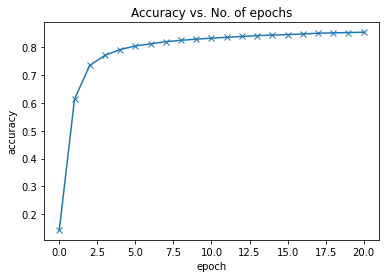

In [ ]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


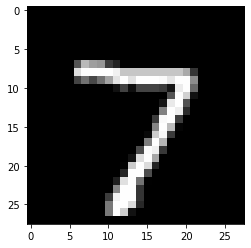

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()
# Since our model cannot work with images, it works with batch of images. Thus we need to convert the images into batch of images containing a single image
# we can do that by calling "img.unsqueeze()": it adds an additional dimension without changing the data. Inshort we just created a batch out of a single image.
# then we're putting that batch into our model 
# Then we will take the prediction with the highest prob. although we have only onw element but since we've created a batch,  we need to follow the procedure
#".item()": extracts the number out of the tensor so that we can see the num. istead of tensor

Label: 7 , Predicted: 7


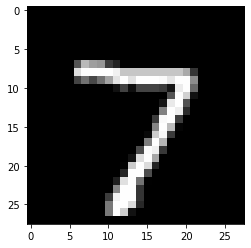

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


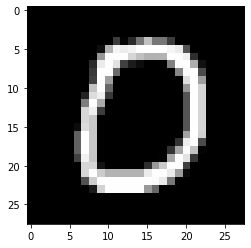

In [ ]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


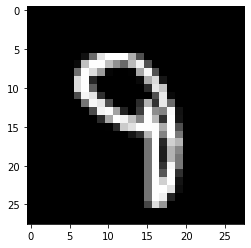

In [ ]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


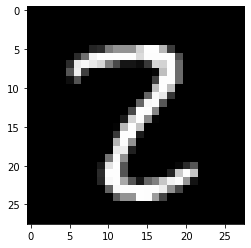

In [ ]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6385003924369812, 'val_acc': 0.8631836175918579}

In [ ]:
torch.save(model.state_dict(), 'mnist-logistic.pth')
# since we have trained the model and now we dont have random weights and baises we will store them to disc so that when we close the project the weights dont go away.
# we save them by using "torch.save". we dont need to save the entire model because it contains self defined func. we just need to store weights
 # we're storing them in "mnist-logistic.pth", .pth is pytorch extension for weights

In [ ]:
model.state_dict()
# It consists of weights and bais inside the linear layer. it is an ordered dictionary. 

OrderedDict([('linear.weight',
              tensor([[-0.0348, -0.0154, -0.0101,  ...,  0.0109,  0.0106,  0.0294],
                      [-0.0167,  0.0052,  0.0164,  ..., -0.0180, -0.0272,  0.0212],
                      [ 0.0301, -0.0312,  0.0342,  ...,  0.0252,  0.0172, -0.0104],
                      ...,
                      [-0.0312, -0.0157, -0.0160,  ...,  0.0146, -0.0048, -0.0156],
                      [ 0.0130, -0.0188, -0.0244,  ..., -0.0116,  0.0350,  0.0158],
                      [ 0.0159, -0.0161, -0.0198,  ...,  0.0129,  0.0060,  0.0349]])),
             ('linear.bias',
              tensor([-7.6912e-02,  6.0273e-02, -1.0912e-02, -1.7774e-02,  1.5225e-02,
                       3.1663e-02,  3.4165e-05,  2.9929e-02, -9.2302e-02, -3.5348e-03]))])

In [ ]:
model2 = MnistModel()

In [ ]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0015,  0.0293, -0.0271,  ..., -0.0349, -0.0120, -0.0167],
                      [-0.0350, -0.0004,  0.0134,  ..., -0.0163, -0.0117, -0.0080],
                      [ 0.0191,  0.0269,  0.0247,  ..., -0.0327,  0.0347, -0.0192],
                      ...,
                      [ 0.0342, -0.0200,  0.0138,  ...,  0.0223,  0.0174, -0.0172],
                      [-0.0228, -0.0304,  0.0295,  ...,  0.0182, -0.0111, -0.0191],
                      [-0.0336,  0.0091, -0.0091,  ..., -0.0061,  0.0248,  0.0196]])),
             ('linear.bias',
              tensor([-0.0266, -0.0090,  0.0171, -0.0166,  0.0158, -0.0342, -0.0105,  0.0015,
                      -0.0080,  0.0109]))])

In [ ]:
evaluate(model2, test_loader)

{'val_loss': 2.2927417755126953, 'val_acc': 0.14960937201976776}

In [ ]:
# as seen above we've created model2, it will have its different weights. So to load the previously saved weights we need to pass
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0348, -0.0154, -0.0101,  ...,  0.0109,  0.0106,  0.0294],
                      [-0.0167,  0.0052,  0.0164,  ..., -0.0180, -0.0272,  0.0212],
                      [ 0.0301, -0.0312,  0.0342,  ...,  0.0252,  0.0172, -0.0104],
                      ...,
                      [-0.0312, -0.0157, -0.0160,  ...,  0.0146, -0.0048, -0.0156],
                      [ 0.0130, -0.0188, -0.0244,  ..., -0.0116,  0.0350,  0.0158],
                      [ 0.0159, -0.0161, -0.0198,  ...,  0.0129,  0.0060,  0.0349]])),
             ('linear.bias',
              tensor([-7.6912e-02,  6.0273e-02, -1.0912e-02, -1.7774e-02,  1.5225e-02,
                       3.1663e-02,  3.4165e-05,  2.9929e-02, -9.2302e-02, -3.5348e-03]))])

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result
# Now we can see the acc and the loss are same as our previous model.

{'val_loss': 0.6385003924369812, 'val_acc': 0.8631836175918579}